# Проверка корректной работы системы сплитования

 А/А-тест проводился с 11.11.2023 по 17.11.2023

In [1]:
import pandas as pd
import pandahouse as ph
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

#### Загрузка данных из Clickhouse и их предварительная обработка

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20231220'
}

In [3]:
# Запрос, который отбирает информацию о лайках и просмотрах по пользователям, 
# которые состоят в0 2 и 3 группах, до введения нового алгоритма
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-11-11' and '2023-11-17'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [4]:
# Количство пользователей в каждой группе
df.groupby('exp_group')['user_id'].count()

exp_group
2    8362
3    8425
Name: user_id, dtype: int64

In [5]:
# Разделение пользователей на два датафрема в зависимости от группы
df_2=df.query('exp_group==2')
df_3=df.query('exp_group==3')

#### Симуляция проведения 10000 A/A-тестов

In [6]:
pvalue = [] # список p-value

# цикл из 1000 итераций
for n in range(10000):
    
    # генерация подвыборки из случайных 500 юзеров без поторений для группы 2
    user_sample_2=df_2.user_id.sample(500, replace=False).tolist()
    sub_sample_2 = df_2[df_2['user_id'].isin(user_sample_2)]
    
    # и для группы 3
    user_sample_3=df_3.user_id.sample(500, replace=False).tolist()
    sub_sample_3 = df_3[df_3['user_id'].isin(user_sample_3)]
    
    # сравнение ctr подвыборок с помощью t-теста
    t_test = stats.ttest_ind(sub_sample_2.ctr,
                sub_sample_3.ctr,
                equal_var=False)
    
    # запись полученного p-value в список
    pvalue.append(t_test[1])

#### Представление результатов

Text(0.5, 0, 'p-value')

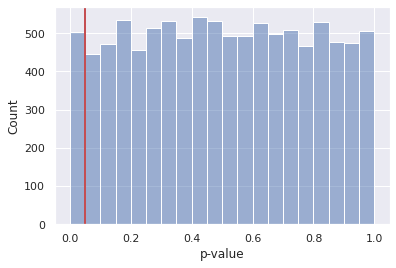

In [7]:
# Построение гистограммы распределения получившихся 10000 p-values
sns.set(rc={'figure.figsize':(12,7)}) # размер графического окна

groups = sns.histplot(pvalue,
              alpha=0.5,
              kde=False, bins=20)

groups.axvline(x=0.05, color='r', linewidth=2) # линия разделения в точке p-value = 0.05 

plt.xlabel("p-value")

In [8]:
print('Процент p values, оказавшийся <= 0.05: ', round((len([i for i in pvalue if i<=0.05])/len(pvalue))*100, 2),'%')

Процент p values, оказавшийся <= 0.05:  5.04 %


#### Вывод

В менее чем 5%, а именно в 4,91% случаях получились статистически значимые различия в группах 2 и 3. Также это видно по гистограмме, где различные p-value распределеные почти равномерно и p-value<=0.05 составляет меньше 1/20 части всех p-value (p-value на гистограмме распределено +- равномерно). Из этого можно сделать вывод, что система сплитования работает корректно.